# Data augmentation

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from exp.nb_09 import *

## PIL transforms

In [ ]:
make_rgb._order=0

In [ ]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_320)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

In [ ]:
def get_il(tfms): return ImageItemList.from_files(path, tfms=tfms)

In [ ]:
il = get_il(tfms)

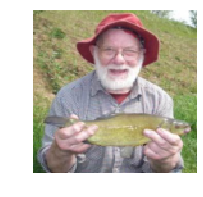

In [ ]:
show_image(il[0])

In [ ]:
img = PIL.Image.open(il.items[0])

### Flip

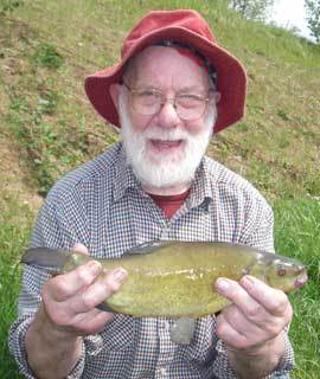

In [ ]:
img

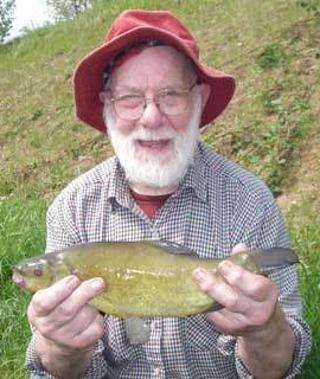

In [ ]:
img.transpose(PIL.Image.FLIP_LEFT_RIGHT)

In [ ]:
#export
from random import random

def show_aug(gen, r=1, c=4, figsize=None):
    if figsize is None: figsize=(c*3,r*3)
    fig,axes = plt.subplots(r,c, figsize=figsize)
    for ax in axes.flat:
        ax.imshow(gen())
        ax.axis('off')

In [ ]:
def pil_random_flip(x): return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random()<0.5 else x

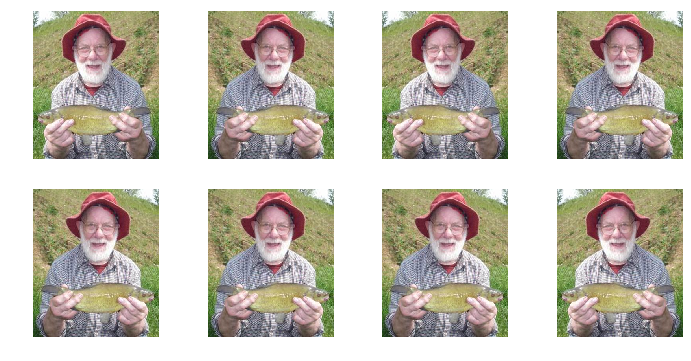

In [ ]:
show_aug(partial(pil_random_flip, img), r=2)

In [ ]:
il1 = get_il(tfms)
il1.items = [il1.items[0]]*8
dl = DataLoader(il1, 8)

In [ ]:
x = next(iter(dl))

In [ ]:
#export
def show_image(im, ax=None, figsize=(3,3)):
    if ax is None: _,ax = plt.subplots(1, 1, figsize=figsize)
    ax.axis('off')
    ax.imshow(im.permute(1,2,0))

def show_batch(x, c=4, figsize=None):
    n = len(x)
    r = int(math.ceil(n/c))
    if figsize is None: figsize=(c*3,r*3)
    fig,axes = plt.subplots(r,c, figsize=figsize)
    for xi,ax in zip(x,axes.flat): show_image(xi, ax)

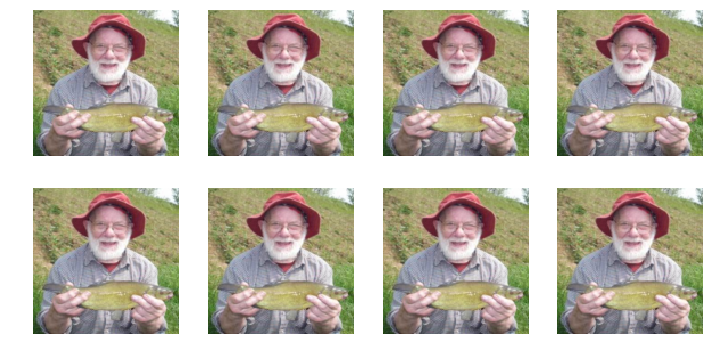

In [ ]:
show_batch(x)

In [ ]:
il1.tfms.append(pil_random_flip)

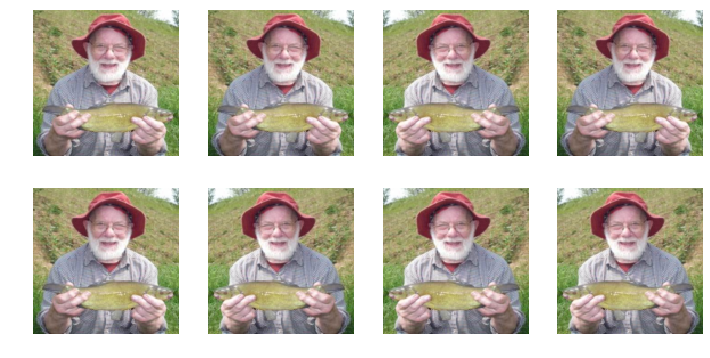

In [ ]:
x = next(iter(dl))
show_batch(x)

In [ ]:
class PilRandomFlip(Transform):
    _order=11
    def __init__(self, p=0.5): self.p=p
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random()<self.p else x

In [ ]:
#export
class PilTransform(Transform): _order=11

class PilRandomFlip(PilTransform):
    def __init__(self, p=0.5): self.p=p
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random()<self.p else x

In [ ]:
del(il1.tfms[-1])
il1.tfms.append(PilRandomFlip(0.8))

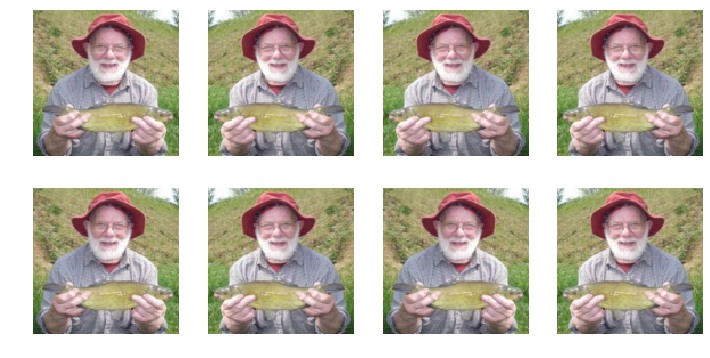

In [ ]:
x = next(iter(dl))
show_batch(x)

### Random crop

In [ ]:
img.size

(320, 379)

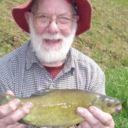

In [ ]:
img.crop((60,60,320,320)).resize((128,128), resample=PIL.Image.BILINEAR)

In [ ]:
cnr2 = (60,60,280,280)
resample = PIL.Image.BILINEAR

In [ ]:
%timeit -n 10 img.crop(cnr2).resize((128,128), resample=resample)

153 µs ± 8.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


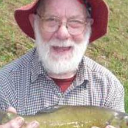

In [ ]:
img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)

In [ ]:
%timeit -n 10 img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)

569 µs ± 4.03 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


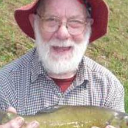

In [ ]:
img.transform((128,128), PIL.Image.QUAD, (60,60,60,280,280,280,280,60), resample=resample)

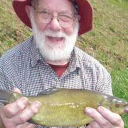

In [ ]:
img.transform((128,128), PIL.Image.QUAD, (60,80,40,320,300,320,320,50), resample=resample)

In [ ]:
%timeit -n 10  img.transform((128,128), PIL.Image.QUAD, (60,60,60,320,320,320,320,60), resample=resample)

583 µs ± 4.35 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
up_tilt =  0.3
dn_tilt =  0.1
lt_tilt = -0.2
rt_tilt = -0.1
top_lt = (50,50)
new_size = 200
bot_rt = (top_lt[0]+new_size,top_lt[1]+new_size)

In [ ]:
up_tilt =  -0.
dn_tilt =  -0.1
lt_tilt = -0.
rt_tilt = -0.
top_lt = (50,50)
new_size = 200
bot_rt = (top_lt[0]+new_size,top_lt[1]+new_size)

In [ ]:
targ_pts_01 = tensor([[-dn_tilt, -lt_tilt], [-up_tilt, 1+lt_tilt], [1+up_tilt, 1-rt_tilt], [1+dn_tilt, rt_tilt]])

In [ ]:
targ_pts_01

tensor([[0.1000, 0.0000],
        [0.0000, 1.0000],
        [1.0000, 1.0000],
        [0.9000, -0.0000]])

In [ ]:
w,h = img.size

In [ ]:
targ_pts = targ_pts_01 * new_size + tensor(top_lt).float()

In [ ]:
targ_pts

tensor([[ 70.,  50.],
        [ 50., 250.],
        [250., 250.],
        [230.,  50.]])

In [ ]:
pts = tuple([int(o.item()) for o in targ_pts.view(-1)])

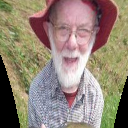

In [ ]:
img.transform((128,128), PIL.Image.QUAD, pts, resample=resample)

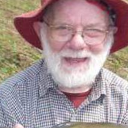

In [ ]:
img.transform((128,128), PIL.Image.QUAD, pts, resample=resample)

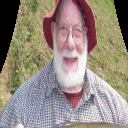

In [ ]:
img.transform((128,128), PIL.Image.QUAD, pts, resample=resample)

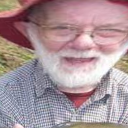

In [ ]:
img.transform((128,128), PIL.Image.QUAD, pts, resample=resample)

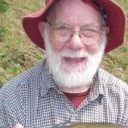

In [ ]:
img.transform((128,128), PIL.Image.QUAD, pts, resample=resample)

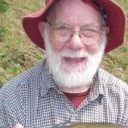

In [ ]:
img.transform((128,128), PIL.Image.EXTENT, (50,50,250,250), resample=resample)

In [ ]:
targ_pts = [[-1-m[3],-1-m[1]], [-1-m[2],1+m[1]], [1+m[3],-1-m[0]], [1+m[2],1+m[0]]]

## Single tensor transforms

In [ ]:
[(o._order,o) for o in sorted(tfms, key=operator.attrgetter('_order'))]

[(0, <function exp.nb_08.make_rgb(item)>),
 (10, <exp.nb_08.ResizeFixed at 0x7f798fd5a7b8>),
 (11, <__main__.PilRandomFlip at 0x7f791d23a7b8>),
 (20, <function exp.nb_08.to_byte_tensor(item)>),
 (30, <function exp.nb_08.to_float_tensor(item)>)]

### Model

In [ ]:
nfs = [32,64,128,256,512]

In [ ]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [ ]:
data = DataBunch(train_dl, valid_dl, 3, 10)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [ ]:
run.fit(1, learn)

train: [1.7537384151543354, tensor(0.3995, device='cuda:0')]
valid: [1.71223388671875, tensor(0.4380, device='cuda:0')]


## Export

In [ ]:
!./notebook2script.py 09_optimizers.ipynb

Converted 09_optimizers.ipynb to nb_09.py
